In [1]:
import os
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap, Normalize

# === 1. Setup Environment and Paths ===
print("--- Setting up environment and paths ---")

# --- Configure Matplotlib ---
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'DejaVu Sans'
sns.set(style="white", context="talk", font_scale=1.0)

--- Setting up environment and paths ---


In [2]:
# --- Input/Output Directories ---
# Base Directory for Models
BASE_MODELS_DIR = "/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/git_repo/Models/optuna_models"

# Path to Global Data Files
MODEL_LINEAGE_PATH = "/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/Fresh_FORGE/Data/Model_24_Q4.csv"

# --- 2. Load Global Lineage Data ---
print("Loading global lineage data...")
try:
    model_lineage_df = pd.read_csv(MODEL_LINEAGE_PATH)
    # Map 'StrippedCellLineName' (e.g., ACH-000001) to 'OncotreeLineage'
    lineage_map = model_lineage_df.set_index('StrippedCellLineName')['OncotreeLineage'].to_dict()
    print("Lineage data loaded successfully.")
except FileNotFoundError:
    print(f"Error: Lineage file not found at {MODEL_LINEAGE_PATH}")
    exit()

# --- Define the specific drug-target pairs to analyze ---
specific_pairs = [
    {'drug_name': 'DAPORINAD', 'target': 'NAMPT'}, 
    {'drug_name': 'AZD8931', 'target': 'ERBB2'},
    {'drug_name': 'BMS-754807', 'target': 'IGF1R'}, 
    {'drug_name': 'DABRAFENIB', 'target': 'BRAF'},
    {'drug_name': 'IMATINIB', 'target': 'MCL1'}, 
    {'drug_name': 'MK-2206', 'target': 'AKT1'},
    {'drug_name': 'TIVANTINIB', 'target': 'MET'}, 
    {'drug_name': 'ULIXERTINIB', 'target': 'MAPK1'}, 
    {'drug_name': 'UPROSERTIB', 'target': 'AKT1'}, 
    {'drug_name': 'TIVOZANIB', 'target': 'PDGFRB'}
]

Loading global lineage data...
Lineage data loaded successfully.


In [3]:
# --- 3. Load Models, Data, and Calculate Benefit Scores ---
print("\n--- Loading models and calculating benefit scores ---")

loaded_scores = {} # To store Series of benefit scores
cached_exp_dfs = {} # Cache loaded expression dataframes to save time/RAM

for pair in specific_pairs:
    drug_name = pair['drug_name']
    target_name = pair['target']
    
    # Construct filename
    model_filename = f"{drug_name}_{target_name}_forgeModel_optuna100.pkl"
    model_path = os.path.join(BASE_MODELS_DIR, model_filename)
    
    pair_label = f"{drug_name}\n({target_name})"

    if not os.path.exists(model_path):
        print(f"--> WARNING: Model not found: {model_path}. Skipping.")
        continue

    try:
        # 1. Load the Pickle Object
        with open(model_path, "rb") as f:
            model = pickle.load(f)
        
        # 2. Get the specific gene list from the model attribute
        try:
            hcg_list = model.hcg_list
        except AttributeError:
            print(f"--> Error: Model for {drug_name} does not have 'hcg_list' attribute.")
            continue

        # 3. Load Expression Data (with caching based on file path)
        # Note: We load the FULL expression file first, then subset later.
        if model.exp_path not in cached_exp_dfs:
            print(f"   Loading expression data from: {model.exp_path}")
            full_exp_df = pd.read_csv(model.exp_path, header=0, index_col=0)
            full_exp_df = full_exp_df[~full_exp_df.index.duplicated(keep='first')]
            cached_exp_dfs[model.exp_path] = full_exp_df
        else:
            full_exp_df = cached_exp_dfs[model.exp_path]

        # 4. Determine Common Cell Lines
        # Combine Train and Test sets for the full heatmap landscape
        model_cells = set(model.train_cellLines) | set(model.test_cellLines)
        common_cells = list(model_cells & set(full_exp_df.index))
        
        if not common_cells:
            print(f"--> WARNING: No common cell lines for {drug_name}.")
            continue
            
        # 5. Prepare Matrices (Subsetting Genes using model.hcg_list)
        try:
            # Subset: Rows = Common Cells, Cols = Specific Genes
            E_subset = full_exp_df.loc[common_cells, hcg_list]
            G = E_subset.to_numpy()
        except KeyError as e:
            print(f"--> Missing genes in expression data for {drug_name}: {e}")
            continue
        
        # Verify shapes
        if G.shape[1] != model.W.shape[0]:
            print(f"--> Shape mismatch for {drug_name}. G columns: {G.shape[1]}, W rows: {model.W.shape[0]}. Skipping.")
            continue

        # 6. Calculate Latent Factors (Z) and Benefit Score
        # Z = G @ W
        Z = G @ model.W
        
        # Benefit = (Z @ hD) - (Z @ hI) = Z @ (hD - hI)
        delta_h = model.hD - model.hI
        benefit_vector = Z @ delta_h
        
        if benefit_vector.ndim > 1:
            benefit_vector = benefit_vector.flatten()
            
        loaded_scores[pair_label] = pd.Series(benefit_vector, index=common_cells)
        print(f"   Processed {drug_name}: {len(common_cells)} cells, {G.shape[1]} genes.")

    except Exception as e:
        print(f"--> ERROR processing {drug_name}: {e}")


--- Loading models and calculating benefit scores ---
   Loading expression data from: /home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/Fresh_FORGE/Data/Exp.csv
   Processed DAPORINAD: 650 cells, 199 genes.
   Processed AZD8931: 491 cells, 171 genes.
   Processed BMS-754807: 677 cells, 200 genes.
   Processed DABRAFENIB: 592 cells, 201 genes.
   Processed IMATINIB: 592 cells, 175 genes.
   Processed MK-2206: 665 cells, 200 genes.
   Processed TIVANTINIB: 267 cells, 200 genes.
   Processed ULIXERTINIB: 510 cells, 197 genes.
   Processed UPROSERTIB: 511 cells, 200 genes.
   Processed TIVOZANIB: 675 cells, 201 genes.


In [4]:
# --- 4. Create the Benefit Score Matrix ---
if not loaded_scores:
    print("\nNo models were successfully processed. Aborting."); exit()

print("\nMerging data into a single matrix...")
benefit_matrix = pd.DataFrame(loaded_scores)
# Drop cell lines that don't have predictions for ALL drugs (intersection)
benefit_matrix = benefit_matrix.dropna()

print(f"Final Matrix Shape: {benefit_matrix.shape} (Cell Lines x Drugs)")

# --- Z-score the benefit scores column-wise ---
benefit_matrix = benefit_matrix.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

# --- 5. Sort Matrix by Lineage ---
print("Sorting data by lineage...")
benefit_matrix['lineage'] = benefit_matrix.index.map(lineage_map).fillna('Unknown')
benefit_matrix.sort_values(by='lineage', inplace=True)

# Colors
sorted_lineages = benefit_matrix['lineage']
unique_lineages = sorted(sorted_lineages.unique())

# Dynamic palette choice based on number of lineages
palette = sns.color_palette("Set2", len(unique_lineages))

lineage_colors = dict(zip(unique_lineages, palette))
row_colors = sorted_lineages.map(lineage_colors).to_frame(name="Lineage")

matrix_for_plotting = benefit_matrix.drop(columns=['lineage'])



Merging data into a single matrix...
Final Matrix Shape: (170, 10) (Cell Lines x Drugs)
Sorting data by lineage...


Generating heatmap...


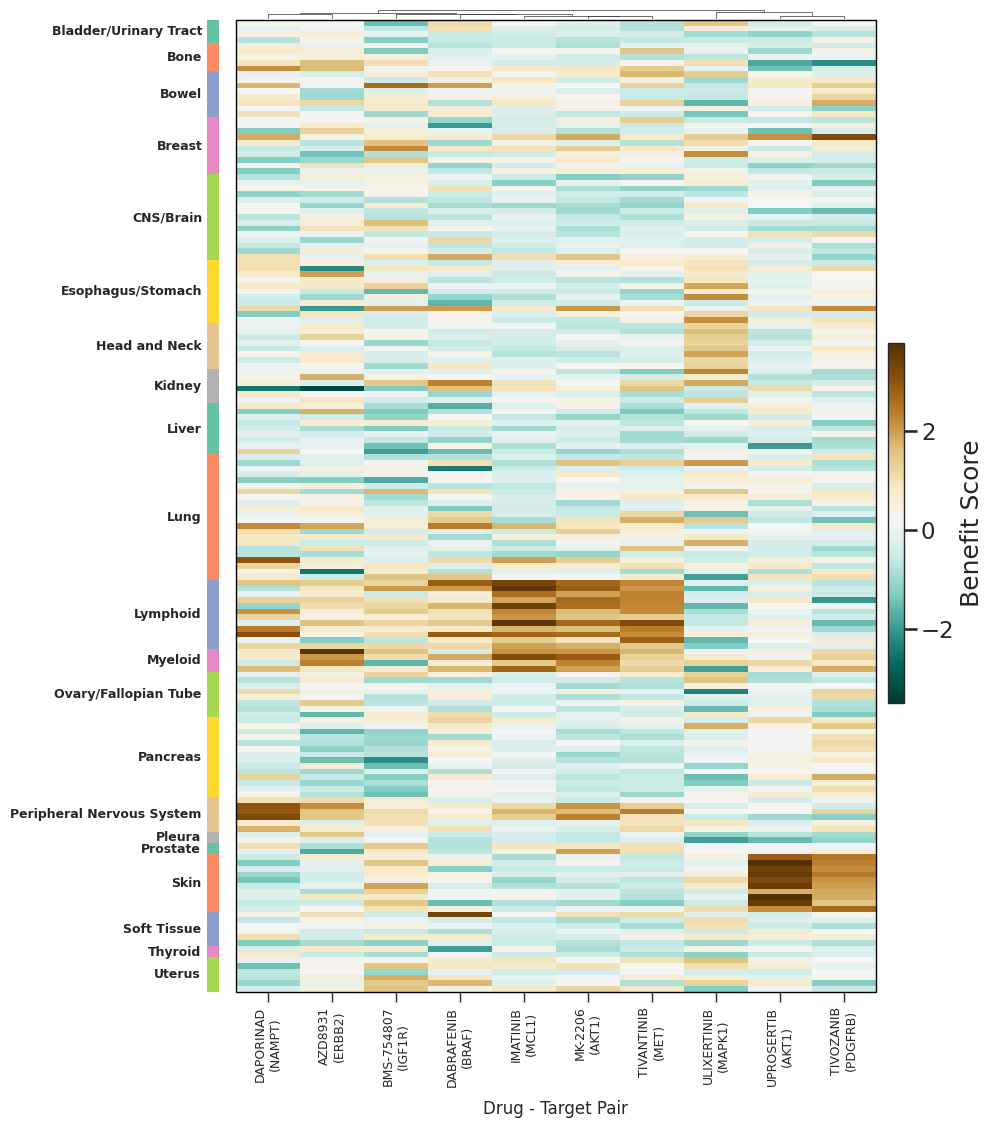

Done.


In [5]:
# --- 6. Generate the Heatmap ---
print("Generating heatmap...")
cmap = 'BrBG_r'

g = sns.clustermap(
    matrix_for_plotting,
    row_cluster=False, 
    col_cluster=True, 
    method='ward',
    cmap=cmap, 
    center=0, 
    row_colors=row_colors,
    figsize=(8, 12), 
    dendrogram_ratio=(.1, .01),
    cbar_pos=None, 
    yticklabels=False, 
    xticklabels=True
)

# Rasterize heatmap for PDF performance
g.ax_heatmap.collections[0].set_rasterized(True)

# --- Custom Annotation Logic (Left Side Lineage Labels) ---
g.ax_row_colors.set_visible(True)
g.ax_row_colors.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
g.ax_row_colors.spines['left'].set_visible(False)
g.ax_row_colors.spines['bottom'].set_visible(False)

# Calculate label positions
lineage_positions = sorted_lineages.to_frame().reset_index().groupby('lineage').agg(
    start=('index', 'first'),
    end=('index', 'last')
)

for lineage, pos in lineage_positions.iterrows():
    try:
        start_idx = matrix_for_plotting.index.get_loc(pos['start'])
        end_idx = matrix_for_plotting.index.get_loc(pos['end'])
        
        if isinstance(start_idx, slice): start_idx = start_idx.start
        if isinstance(end_idx, slice): end_idx = end_idx.stop - 1
            
        center_pos = (start_idx + end_idx + 1) / 2
        total_rows = len(matrix_for_plotting)
        y_pos_normalized = (total_rows - center_pos) / total_rows
        
        bbox = g.ax_row_colors.get_position()
        
        # Shrink the color bar width slightly
        orig_pos = g.ax_row_colors.get_position()
        new_pos = [orig_pos.x0 - 0.0001, orig_pos.y0, 0.015, orig_pos.height]
        g.ax_row_colors.set_position(new_pos)
        
        final_y = bbox.y0 + y_pos_normalized * bbox.height
        
        g.fig.text(
            bbox.x0 - 0.008, 
            final_y,
            lineage,
            ha='right', 
            va='center', 
            fontsize=9,
            fontweight='bold'
        )
    except Exception as e:
        pass

# --- Custom Colorbar (Right Side) ---
cbar_ax = g.fig.add_axes([0.98, 0.40, 0.02, 0.3]) # [left, bottom, width, height]
norm = plt.Normalize(vmin=matrix_for_plotting.values.min(), vmax=matrix_for_plotting.values.max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
g.fig.colorbar(sm, cax=cbar_ax, orientation='vertical', label='Benefit Score')
cbar_ax.yaxis.set_label_position('right')
cbar_ax.yaxis.set_ticks_position('right')
for spine in cbar_ax.spines.values(): spine.set_linewidth(1)

# --- Standard Aesthetics ---
g.ax_heatmap.set_xlabel("Drug - Target Pair", fontsize=12, labelpad=10)
g.ax_heatmap.set_ylabel("")
for tick_label in g.ax_heatmap.get_xticklabels():
    tick_label.set_rotation(90)
    tick_label.set_horizontalalignment('center')
    tick_label.set_fontsize(9)
g.ax_heatmap.set_yticks([])
g.ax_heatmap.tick_params(axis='y', length=0)

# --- Explicit X-axis ticks ---
ax = g.ax_heatmap

# Number of columns
n_cols = matrix_for_plotting.shape[1]

# Tick positions = center of each column
ax.set_xticks(np.arange(n_cols) + 0.5)

# Tick labels = column names
ax.set_xticklabels(
    matrix_for_plotting.columns,
    rotation=90,
    ha="center",
    fontsize=9
)

ax.tick_params(axis='x', bottom=True, top=False, length=7, width=1)


# --- Add Black Border ---
x0, y0, width, height = g.ax_heatmap.get_position().bounds
rect = patches.Rectangle(
    (x0, y0), width, height,
    linewidth=1, edgecolor='black', facecolor='none',
    transform=g.fig.transFigure, zorder=10
)
g.fig.patches.append(rect)

# --- Save ---
#save_path = os.path.join(OUTPUT_DIR_HEATMAP, "Benefit_score_heatmap.pdf")
#print(f"Saving plot to {save_path}...")
#plt.savefig('/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/git_repo/Figs/Fig5/Benefit_score_heatmap.pdf', dpi=600, bbox_inches='tight')
plt.show()
print("Done.")

In [6]:
# %%
# --- 5b. Analyze Top Lineages per Drug-Target Pair ---
print("\n--- Identifying Top 3 Lineages per Drug-Target Pair ---")

# 1. Calculate the mean benefit score for each lineage per drug
#    (Group by lineage, calculate mean, and transpose for easier iteration if needed, 
#     but standard columns are fine)
lineage_means = benefit_matrix.groupby('lineage').mean()

# 2. Iterate through each drug-target column to find the top 3
top_lineage_data = []

for drug_col in lineage_means.columns:
    # Use nlargest to get the top 3 lineages for this specific drug
    top_3 = lineage_means[drug_col].nlargest(3)
    
    # Store the results
    rank = 1
    for lineage, score in top_3.items():
        top_lineage_data.append({
            'Drug_Target_Pair': drug_col,
            'Rank': rank,
            'Lineage': lineage,
            'Average_Benefit_Score': score
        })
        rank += 1

# 3. Create the DataFrame
top_lineages_df = pd.DataFrame(top_lineage_data)

# 4. Display the results
print(top_lineages_df)

# Optional: Save to CSV
# top_lineages_df.to_csv("Top_3_Lineages_Per_Drug.csv", index=False)

# Optional: Pivot for a cleaner "wide" view
top_lineages_pivot = top_lineages_df.pivot(
    index='Drug_Target_Pair', 
    columns='Rank', 
    values=['Lineage', 'Average_Benefit_Score']
)
print("\n--- Wide View (Pivot) ---")
print(top_lineages_pivot)


--- Identifying Top 3 Lineages per Drug-Target Pair ---
        Drug_Target_Pair  Rank                    Lineage  \
0     DAPORINAD\n(NAMPT)     1                   Lymphoid   
1     DAPORINAD\n(NAMPT)     2                    Myeloid   
2     DAPORINAD\n(NAMPT)     3                     Uterus   
3       AZD8931\n(ERBB2)     1              Head and Neck   
4       AZD8931\n(ERBB2)     2          Esophagus/Stomach   
5       AZD8931\n(ERBB2)     3                     Kidney   
6    BMS-754807\n(IGF1R)     1  Peripheral Nervous System   
7    BMS-754807\n(IGF1R)     2                       Bone   
8    BMS-754807\n(IGF1R)     3                   Lymphoid   
9     DABRAFENIB\n(BRAF)     1                       Skin   
10    DABRAFENIB\n(BRAF)     2                    Myeloid   
11    DABRAFENIB\n(BRAF)     3                   Pancreas   
12      IMATINIB\n(MCL1)     1                    Myeloid   
13      IMATINIB\n(MCL1)     2                   Lymphoid   
14      IMATINIB\n(MCL1)    

In [7]:
top_lineages_pivot

Lineage                             \
Rank                                          1                          2   
Drug_Target_Pair                                                             
AZD8931\n(ERBB2)                  Head and Neck          Esophagus/Stomach   
BMS-754807\n(IGF1R)   Peripheral Nervous System                       Bone   
DABRAFENIB\n(BRAF)                         Skin                    Myeloid   
DAPORINAD\n(NAMPT)                     Lymphoid                    Myeloid   
IMATINIB\n(MCL1)                        Myeloid                   Lymphoid   
MK-2206\n(AKT1)                        Lymphoid                    Myeloid   
TIVANTINIB\n(MET)                      Lymphoid                    Myeloid   
TIVOZANIB\n(PDGFRB)                     Myeloid  Peripheral Nervous System   
ULIXERTINIB\n(MAPK1)                       Skin                    Myeloid   
UPROSERTIB\n(AKT1)                     Prostate                       Skin   

                                                Average_Benefit_Score  \
Rank                                          3                     1   
Drug_Target_Pair                                                        
AZD8931\n(ERBB2)                         Kidney              1.320549   
BMS-754807\n(IGF1R)                    Lymphoid              2.030888   
DABRAFENIB\n(BRAF)                     Pancreas              3.104815   
DAPORINAD\n(NAMPT)                       Uterus              1.318188   
IMATINIB\n(MCL1)                       Prostate              2.236462   
MK-2206\n(AKT1)       Peripheral Nervous System              2.496309   
TIVANTINIB\n(MET)     Peripheral Nervous System              2.174814   
TIVOZANIB\n(PDGFRB)                        Bone              2.165232   
ULIXERTINIB\n(MAPK1)                   Pancreas              2.063631   
UPROSERTIB\n(AKT1)                       Uterus              1.016605   

                                          
Rank                         2         3  
Drug_Target_Pair                          
AZD8931\n(ERBB2)      0.901136  0.712755  
BMS-754807\n(IGF1R)   0.829546  0.781039  
DABRAFENIB\n(BRAF)    0.440293  0.168618  
DAPORINAD\n(NAMPT)    0.860667  0.612403  
IMATINIB\n(MCL1)      2.066761  1.331944  
MK-2206\n(AKT1)       2.300679  0.561435  
TIVANTINIB\n(MET)     1.298853  1.065431  
TIVOZANIB\n(PDGFRB)   1.020307  0.745473  
ULIXERTINIB\n(MAPK1)   1.18407  0.693523  
UPROSERTIB\n(AKT1)    0.943044  0.808654